# Классификация текстов `emotion` моделью `distilBERT`.

## Датасет

### Описание

Датасет `emotion` содержит английские сообщения из Твитера, помеченные одним из следующих эмоций: `anger`, `fear`, `joy`, `love`, `sadness` и `surprise`.

In [1]:
from datasets import load_dataset

emotions = load_dataset("emotion")
emotions

/home/misha/.pyenv/versions/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [2]:
emotions["train"][:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [3]:
emotions["train"].features["label"]

ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

### Распределение классов

In [4]:
emotions.set_format("pandas")
df = emotions["train"][:]
emotions.reset_format()
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [5]:
df["label_name"] = df["label"].apply(
    lambda x: emotions["train"].features["label"].int2str(x)
)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Text(0.5, 1.0, 'Frequency of Classes')

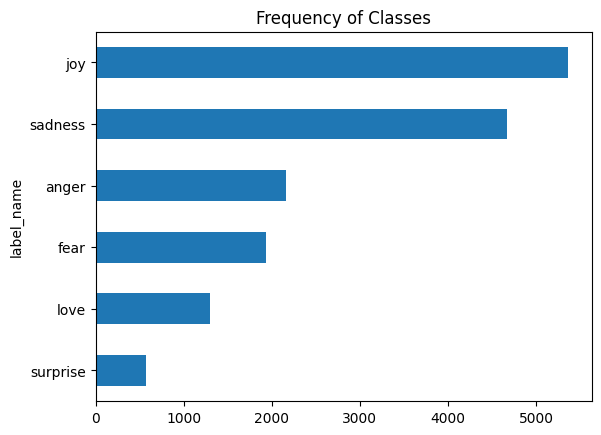

In [6]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")

Есть дисбаланс классов. Можно
- повторно выбрать образцы из меньших классов;
- сократить большие классы;
- собрать больше данных для маленьких классов.

Но мы будем работать с несбалансированными данными.

### Распределение длин текстов (по словам)

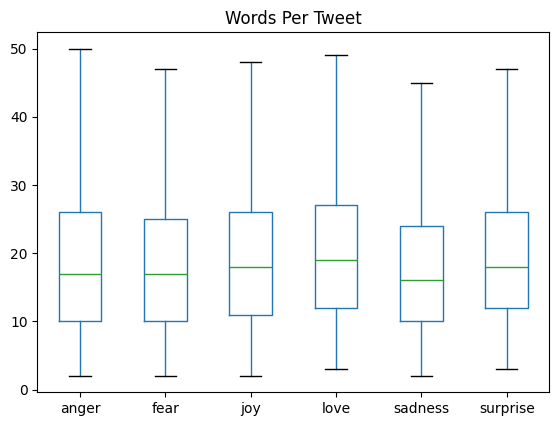

In [7]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.show()

Длины всех текстов должны уместиться в контекстное окно модели (512 токенов у `distilBERT`). Если не будет умещаться, то можно будет обрезать текст.

## Токенизатор

`distilBERT` токенизатор основан на алгоритме `WordPiece`.

In [8]:
from transformers import DistilBertTokenizer

MODEL_CKPT = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_CKPT)

In [9]:
text = "Tokenizing text is a core task of nlp."
encoded_text = tokenizer(text)

In [10]:
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [11]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [12]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp . [SEP]


### Токенизация

In [13]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=False, truncation=True)

In [14]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [15]:
tokenized_datasets = emotions.map(tokenize, batched=True).remove_columns(
    "text"
)

In [16]:
len(emotions["train"].features["label"].names)

6

In [17]:
tokenized_datasets["train"][:2]

{'label': [0, 0],
 'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102],
  [101,
   1045,
   2064,
   2175,
   2013,
   3110,
   2061,
   20625,
   2000,
   2061,
   9636,
   17772,
   2074,
   2013,
   2108,
   2105,
   2619,
   2040,
   14977,
   1998,
   2003,
   8300,
   102]],
 'attention_mask': [[1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [18]:
tokenized_datasets["train"][:2]

{'label': [0, 0],
 'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102],
  [101,
   1045,
   2064,
   2175,
   2013,
   3110,
   2061,
   20625,
   2000,
   2061,
   9636,
   17772,
   2074,
   2013,
   2108,
   2105,
   2619,
   2040,
   14977,
   1998,
   2003,
   8300,
   102]],
 'attention_mask': [[1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

## DataLoader и DataCollator

In [19]:
NUM_LABELS = len(emotions["train"].features["label"].names)  # 6
BATCH_SIZE = 256

In [20]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer, padding=True, return_tensors="pt"
)

train_dataloader = DataLoader(
    tokenized_datasets["train"],
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=data_collator,
    num_workers=8,
)

validation_dataloader = DataLoader(
    tokenized_datasets["validation"],
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=data_collator,
    num_workers=8,
)

test_dataloader = DataLoader(
    tokenized_datasets["validation"],
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=data_collator,
    num_workers=8,
)

In [21]:
data_collator(tokenized_datasets["train"][:2])

{'input_ids': tensor([[  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101,  1045,  2064,  2175,  2013,  3110,  2061, 20625,  2000,  2061,
          9636, 17772,  2074,  2013,  2108,  2105,  2619,  2040, 14977,  1998,
          2003,  8300,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'labels': tensor([0, 0])}

In [22]:
next(iter(train_dataloader))["input_ids"]

tensor([[ 101, 1045, 2514,  ...,    0,    0,    0],
        [ 101, 1045, 2347,  ...,    0,    0,    0],
        [ 101, 1045, 2514,  ...,    0,    0,    0],
        ...,
        [ 101, 1045, 2514,  ...,    0,    0,    0],
        [ 101, 1045, 2514,  ...,    0,    0,    0],
        [ 101, 1045, 2113,  ...,    0,    0,    0]])

## Обучение модели

In [23]:
import pytorch_lightning as pl


from transformers import DistilBertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score


class plClassifier(pl.LightningModule):
    def __init__(self, num_labels, num_training_steps):
        super().__init__()
        self.save_hyperparameters()
        self.num_training_steps = num_training_steps
        self.model = DistilBertForSequenceClassification.from_pretrained(
            MODEL_CKPT, num_labels=num_labels
        )
        metrics = MetricCollection(
            {
                "accuracy": MulticlassAccuracy(
                    num_classes=num_labels, average="weighted"
                ),
                "f1_score": MulticlassF1Score(
                    num_classes=num_labels, average="weighted"
                ),
            }
        )

        self.train_metrics = metrics.clone(prefix="train_")

        self.val_metrics = metrics.clone(prefix="val_")

        self.test_metrics = metrics.clone(prefix="test_")

    def forward(self, batch):
        return self.model(**batch)

    def training_step(self, batch, batch_idx):
        outputs = self(batch)
        loss = outputs.loss
        self.train_metrics.update(outputs.logits, batch["labels"])
        self.log(
            "train_loss", loss, on_step=False, on_epoch=True, prog_bar=True
        )
        self.log_dict(self.train_metrics, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self(batch)
        loss = outputs.loss
        self.val_metrics.update(outputs.logits, batch["labels"])
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log_dict(
            self.val_metrics, on_step=False, on_epoch=True, prog_bar=True
        )

    def test_step(self, batch, batch_idx):
        outputs = self(batch)
        loss = outputs.loss
        self.test_metrics.update(outputs.logits, batch["labels"])
        self.log_dict(
            self.val_metrics, on_step=False, on_epoch=True, prog_bar=True
        )

    def configure_optimizers(self):
        optimizer = AdamW(
            self.model.parameters(),
            lr=2e-5,
        )
        scheduler = get_scheduler(
            "linear",
            optimizer,
            num_training_steps=self.num_training_steps,
            num_warmup_steps=0,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",  # обновлять каждый шаг
                "frequency": 1,
            },
        }

In [24]:
from pytorch_lightning.callbacks import TQDMProgressBar, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pathlib import Path

NUM_EPOCHS = 5
NUM_TRAINING_STEPS = len(train_dataloader) * NUM_EPOCHS
EXPERIMENTS_DIR = Path("Text-Classification")
CHECKPOINT_DIR = EXPERIMENTS_DIR / "checkpoints"
CHECKPOINT_DIR.mkdir(exist_ok=True, parents=True)

callbacks = [
    TQDMProgressBar(leave=True),
    ModelCheckpoint(
        dirpath=CHECKPOINT_DIR,
        filename="last",
        save_last=True,
        save_top_k=0,
    ),
]

logger = CSVLogger(save_dir=EXPERIMENTS_DIR, name="logs")

last_ckpt_path = CHECKPOINT_DIR / "last.ckpt"

ckpt_path = last_ckpt_path if last_ckpt_path.exists() else None

trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    devices=1,
    callbacks=callbacks,
    logger=logger if not ckpt_path else False,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [25]:
pl_model = plClassifier(NUM_LABELS, NUM_TRAINING_STEPS)
trainer.fit(
    pl_model, train_dataloader, validation_dataloader, ckpt_path=ckpt_path
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are using a CUDA device ('NVIDIA GeForce RTX 5070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at Text-Classification/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                                | Params | Mode 
-----------------------------------------------------------------------------

`Trainer.fit` stopped: `max_epochs=5` reached.


## Confusion Matrix

In [26]:
import torch

outputs = trainer.predict(pl_model, validation_dataloader)
logits = torch.cat([output.logits for output in outputs])
labels = torch.cat([batch["labels"] for batch in validation_dataloader])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 13.27it/s]


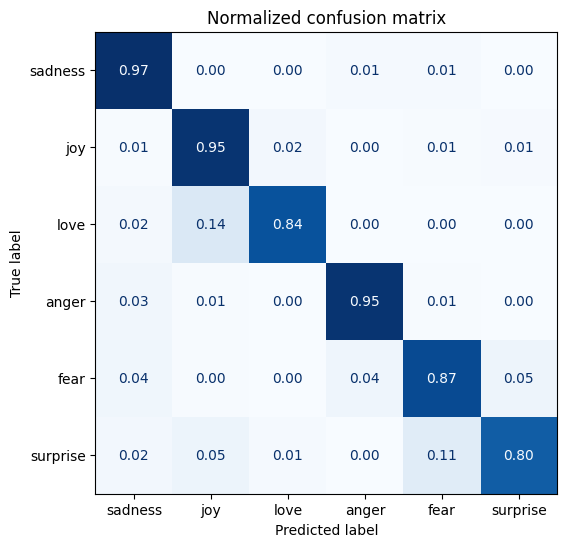

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()


y_preds = torch.argmax(logits, dim=-1).numpy()
y_true = labels.numpy()
labels_names = emotions["train"].features["label"].names

plot_confusion_matrix(y_preds, y_true, labels_names)

## Анализ ошибок

Отсортируем результаты на валидационной выборке по убыванию и возрастанию, чтобы посмотреть, в каких классах модель наиболее уверена, а в каких наименее.

In [28]:
from torch.nn.functional import cross_entropy
import numpy as np

losses = cross_entropy(logits, labels, reduction="none").numpy()
emotions["validation"].set_format("pandas")
df_val = emotions["validation"][:]
emotions["validation"].reset_format()

int2str = emotions["train"].features["label"].int2str

df_val["label"] = df_val["label"].apply(lambda x: int2str(x))
df_val["label_pred"] = y_preds
df_val["label_pred"] = df_val["label_pred"].apply(lambda x: int2str(x))
df_val["loss"] = losses

In [29]:
import pandas as pd

with pd.option_context("display.max_colwidth", None):
    display(df_val.sort_values(by="loss", ascending=False).head(10))

,text,label,label_pred,loss
405,i have been feeling extraordinarily indecisive about which innocent crush fabrics i love the most,fear,joy,5.383275
1500,i guess we would naturally feel a sense of loneliness even the people who said unkind things to you might be missed,anger,sadness,5.244710
1963,i called myself pro life and voted for perry without knowing this information i would feel betrayed but moreover i would feel that i had betrayed god by supporting a man who mandated a barely year old vaccine for little girls putting them in danger to financially support people close to him,joy,sadness,5.228166
1111,im lazy my characters fall into categories of smug and or blas people and their foils people who feel inconvenienced by smug and or blas people,joy,fear,5.002943
1950,i as representative of everything thats wrong with corporate america and feel that sending him to washington is a ludicrous idea,surprise,sadness,4.923075
1870,i guess i feel betrayed because i admired him so much and for someone to do this to his wife and kids just goes beyond the pale,joy,sadness,4.706682
318,i felt ashamed of these feelings and was scared because i knew that something wrong with me and thought i might be gay,fear,sadness,4.378699
1509,i guess this is a memoir so it feels like that should be fine too except i dont know something about such a deep amount of self absorption made me feel uncomfortable,joy,fear,4.012887
292,i can say is that i feel like myself when i put on a skirt heels and lipstick and when i wear clothing which has come to be accepted as neutral and nondescript like a t shirt and jeans i dont feel like myself,love,joy,3.565164
1683,i had applied for a job and they had assured me that the exams would take place a few months later a week later i went to obtain some more information and they told me that the exams had already taken place,anger,joy,3.464286


In [30]:
with pd.option_context("display.max_colwidth", None):
    display(df_val.sort_values(by="loss", ascending=True).head(10))

,text,label,label_pred,loss
1090,i dont know what it is about me and sweets they make me feel bouncy and pleased with everything,joy,joy,0.012618
632,i feel he is an terrific really worth bet,joy,joy,0.012698
1198,i feel like i should also mention that there was some content that i wasnt thrilled with either,joy,joy,0.012815
262,i feel like its one of the most valuable tools in my art box,joy,joy,0.012938
578,i got to christmas feeling positive about the future and hopeful that hospital admissions were finally behind me,joy,joy,0.012970
1012,i definitely succumbed to pre holiday sales but i feel good going into the holiday season i probably shouldnt say that though,joy,joy,0.012973
1688,i feel very very rich and fulfilled and a part of the grand scheme of the universe,joy,joy,0.013023
491,i feel like it is a valuable addition to any teachers repertoire,joy,joy,0.013025
1873,i feel practically virtuous this month i have not exceeded my target of only buying things,joy,joy,0.013043
722,i am feeling so comfortable and so happy he says,joy,joy,0.013095


## Инференс

In [31]:
from transformers import pipeline

model = pl_model.model
model.config.id2label = {k: int2str(k) for k in model.config.id2label}
model.config.label2id = {int2str(k): k for k in model.config.id2label}
tokenizer

classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    top_k=None,
)

Device set to use cuda:0


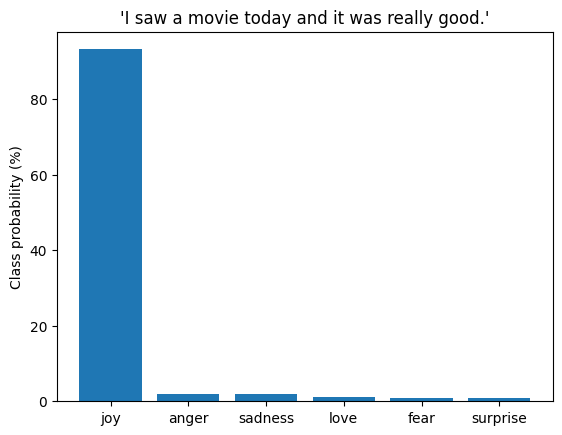

In [34]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet)
preds_df = pd.DataFrame(preds[0])
plt.bar(preds_df["label"], 100 * preds_df["score"], color="C0")
plt.title(f"'{custom_tweet}'")
plt.ylabel("Class probability (%)")
plt.show()